# Python ML Project

## I. Import libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import csv
from datetime import datetime as dt
from sklearn.model_selection import (train_test_split,cross_val_score,RepeatedStratifiedKFold,RandomizedSearchCV,KFold)
from sklearn.preprocessing import (LabelEncoder,
    RobustScaler,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import (RocCurveDisplay,PrecisionRecallDisplay,
    roc_auc_score,
    classification_report,
    confusion_matrix,ConfusionMatrixDisplay,
    fbeta_score,f1_score,recall_score,
)

## II. EDA and feature engineering

### 2.1 Importing data and preprocessing

In [2]:
ddir = '../Data/books.csv'
#ddir = '..\\Data\\books.csv'

#Rows with number of elements not consistent with the number of columns in the header
with open(ddir, encoding="utf8") as fd:
    reader=csv.reader(fd)
    lines = list(reader)
    nbColumns = len(lines[0])
    print("There are {} column names in the header.".format(nbColumns))
    RowsToPrep=[[idx, row] for idx, row in enumerate(lines) if len(row) != nbColumns]
fd.close()

print("There are {} rows with number of elements not consistent with the number of columns in the header of the file.\n".format(len(RowsToPrep)))
for row in RowsToPrep:
    print(row)
#We can see that number of columns inconsistency is due to additionnal comma with the author name(s).
#Let's merge those columns then to not loose data from the dataset

There are 12 column names in the header.
There are 4 rows with number of elements not consistent with the number of columns in the header of the file.

[3349, ['12224', 'Streetcar Suburbs: The Process of Growth in Boston  1870-1900', 'Sam Bass Warner', ' Jr./Sam B. Warner', '3.58', '0674842111', '9780674842113', 'en-US', '236', '61', '6', '4/20/2004', 'Harvard University Press']]
[4703, ['16914', "The Tolkien Fan's Medieval Reader", 'David E. Smith (Turgon of TheOneRing.net', ' one of the founding members of this Tolkien website)/Verlyn Flieger/Turgon (=David E. Smith)', '3.58', '1593600119', '9781593600112', 'eng', '400', '26', '4', '4/6/2004', 'Cold Spring Press']]
[5878, ['22128', 'Patriots (The Coming Collapse)', 'James Wesley', ' Rawles', '3.63', '156384155X', '9781563841552', 'eng', '342', '38', '4', '1/15/1999', 'Huntington House Publishers']]
[8980, ['34889', "Brown's Star Atlas: Showing All The Bright Stars With Full Instructions How To Find And Use Them For Navigational Purpo

In [3]:
#Build the corrected file by duplicating each line without the two problematic column values. Then insert those column values after merging them.
prepDdir = '../Data/books_prep.csv'
#prepDdir = '..\Data\books_prep.csv'

for elt in RowsToPrep:
    prepRows = [a for idx,a in enumerate(elt[1]) if idx not in [2,3]]
    prepRows.insert(2, elt[1][2] + " -" + elt[1][3])
    elt[1] = prepRows
    print("Line {} before preprocessing\n {}".format(elt[0], lines[elt[0]]))
    lines[elt[0]] = prepRows
    print("Line {} after preprocessing\n {}\n".format(elt[0], lines[elt[0]]))

with open(prepDdir, 'w', newline='', encoding="utf8") as file:
    writer = csv.writer(file)
    writer.writerows(lines)
file.close()

Line 3349 before preprocessing
 ['12224', 'Streetcar Suburbs: The Process of Growth in Boston  1870-1900', 'Sam Bass Warner', ' Jr./Sam B. Warner', '3.58', '0674842111', '9780674842113', 'en-US', '236', '61', '6', '4/20/2004', 'Harvard University Press']
Line 3349 after preprocessing
 ['12224', 'Streetcar Suburbs: The Process of Growth in Boston  1870-1900', 'Sam Bass Warner - Jr./Sam B. Warner', '3.58', '0674842111', '9780674842113', 'en-US', '236', '61', '6', '4/20/2004', 'Harvard University Press']

Line 4703 before preprocessing
 ['16914', "The Tolkien Fan's Medieval Reader", 'David E. Smith (Turgon of TheOneRing.net', ' one of the founding members of this Tolkien website)/Verlyn Flieger/Turgon (=David E. Smith)', '3.58', '1593600119', '9781593600112', 'eng', '400', '26', '4', '4/6/2004', 'Cold Spring Press']
Line 4703 after preprocessing
 ['16914', "The Tolkien Fan's Medieval Reader", 'David E. Smith (Turgon of TheOneRing.net - one of the founding members of this Tolkien website)/

In [4]:
df = pd.read_csv(prepDdir,sep=",",index_col="bookID")

##### Check data structure

In [5]:
df.shape

(11127, 11)

In [6]:
df.dtypes

title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

In [7]:
#Remove the extra space in column '  num_pages'
df = df.rename(columns={'  num_pages': 'num_pages'})

##### Checking missing values

In [8]:
df.isna().sum()

title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

##### Look at first and last records

In [9]:
df.head()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [10]:
df.tail()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press
45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books
45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books
45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco
45641,Las aventuras de Tom Sawyer,Mark Twain,3.91,8497646983,9788497646987,spa,272,113,12,5/28/2006,Edimat Libros


In [11]:
##### Possible questions

##### Regression problem : What is the expected rating of a book according to information provided in other columns.
##### Classification problem : What is the expected "rating class" (High or Low/Medium) of a book according to information provided in other columns.

##### Transform date column

In [12]:
#Checking dates before transforming them to be reading as it should
tempDf = df.copy()
publication_date = pd.to_datetime(tempDf['publication_date'],format='%m/%d/%Y', errors='coerce')
print("*** Number of invalid parsing set to NaT: {}.\n".format(publication_date.isna().sum()))

*** Number of invalid parsing set to NaT: 2.



In [13]:
#There are some invalid dates. Let's display the corresponding lines.
tempIndex = list(tempDf.loc[publication_date.isna(),:].index)
print("*** Index of invalid publication dates : {}\n".format(tempIndex))
print("*** Invalid publication dates : {}\n".format(tempDf.loc[publication_date.isna(),['publication_date']]))
print("*** Records with invalid parsing set to NaT in tempDf for publication date : : {}\n".format(df.loc[tempIndex]))

*** Index of invalid publication dates : [31373, 45531]

*** Invalid publication dates :        publication_date
bookID                 
31373        11/31/2000
45531         6/31/1982

*** Records with invalid parsing set to NaT in tempDf for publication date : :                                                     title  \
bookID                                                      
31373   In Pursuit of the Proper Sinner (Inspector Lyn...   
45531          Montaillou  village occitan de 1294 à 1324   

                                                authors  average_rating  \
bookID                                                                    
31373                                 Elizabeth  George            4.10   
45531   Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie            3.96   

              isbn         isbn13 language_code  num_pages  ratings_count  \
bookID                                                                      
31373   0553575104  9780553575101  

In [14]:
#We have only two lines with inconsistence day for the displayed month. Therefore we update the date by the 
#ones retreived on Internet.
#https://www.goodreads.com/book/show/31373.In_Pursuit_of_the_Proper_Sinner?ref=nav_sb_ss_1_13
#https://www.chasse-aux-livres.fr/prix/0553575104/in-pursuit-of-the-proper-sinner-elizabeth-george
#31/10/2000
#"https://www.goodreads.com/book/show/45531
#30/06/1982

#This change will not impact the following results as we are going to focus only on the publication year.

df['publication_date'].replace('11/31/2000', '10/31/2000', inplace=True)
df['publication_date'].replace('6/31/1982', '6/30/1982', inplace=True)

In [15]:
#Check that everything is ok with the dates now.
tempDf = df.copy()
publication_date = pd.to_datetime(tempDf['publication_date'],format='%m/%d/%Y', errors='coerce')
print("*** Number of invalid parsing set to NaT: {}.\n".format(publication_date.isna().sum()))

*** Number of invalid parsing set to NaT: 0.



In [16]:
#As everything is ok now, transform date in the oroginal dataframe column to be reading as it should
df['publication_date']=pd.to_datetime(df['publication_date'],format='%m/%d/%Y')

#create a new variable with the publication date to analize it later
df['publicationYear'] = pd.DatetimeIndex(df['publication_date']).year

In [17]:
#Check isbn13 as object since it is an ID
df['isbn13']=df['isbn13'].astype('object')
#Check of the types after transformation
df.dtypes

title                         object
authors                       object
average_rating               float64
isbn                          object
isbn13                        object
language_code                 object
num_pages                      int64
ratings_count                  int64
text_reviews_count             int64
publication_date      datetime64[ns]
publisher                     object
publicationYear                int32
dtype: object

##### Transform language code column

In [18]:
#checking how many different languages and if it's possible regrouping
df[['language_code','title']].groupby('language_code').count()

,title
language_code,
ale,1
ara,1
en-CA,7
en-GB,214
en-US,1409
eng,8911
enm,3
fre,144
ger,99


In [19]:
#regrouping cathegories
def map_leng_categories(category):
    if category in ["en-CA","en-GB","en-US",'eng']:
        return 'eng'
    elif category in ['fre', 'spa', 'ger', 'jpn']:
        return category
    else:
        return 'other'

# Apply the function, create new column
df['language_code_grouped'] = df['language_code'].apply(map_leng_categories)

df[['language_code_grouped','title']].groupby('language_code_grouped').count()


,title
language_code_grouped,
eng,10541
fre,144
ger,99
jpn,46
other,79
spa,218


##### Transform average rate column to categories (for the classification problem) 

In [20]:
df['average_rating'].median()

3.96

In [21]:
def f(row):
    if row['average_rating'] > 4.0:
        val = 'HigRat'
    else:
        val = 'LMRat'
    return val

df['catRating'] = df.apply(f, axis=1)

#check the proportion
percentage = df.groupby('catRating')['title'].count().reset_index()
percentage['Percentage'] = 100 * percentage['title']  / percentage['title'].sum()
percentage

,catRating,title,Percentage
0,HigRat,4735,42.554148
1,LMRat,6392,57.445852


### 2.2 Analyzing data 

##### Descriptive statistics

In [22]:
df.select_dtypes(["float64","int64","int32"]).describe()

,average_rating,num_pages,ratings_count,text_reviews_count,publicationYear
count,11127.000000,11127.000000,1.112700e+04,11127.000000,11127.000000
mean,3.933631,336.376921,1.793641e+04,541.854498,2000.167520
std,0.352445,241.127305,1.124794e+05,2576.176608,8.248836
min,0.000000,0.000000,0.000000e+00,0.000000,1900.000000
25%,3.770000,192.000000,1.040000e+02,9.000000,1998.000000
50%,3.960000,299.000000,7.450000e+02,46.000000,2003.000000
75%,4.135000,416.000000,4.993500e+03,237.500000,2005.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000,2020.000000


##### Histogram and kernel density estimate

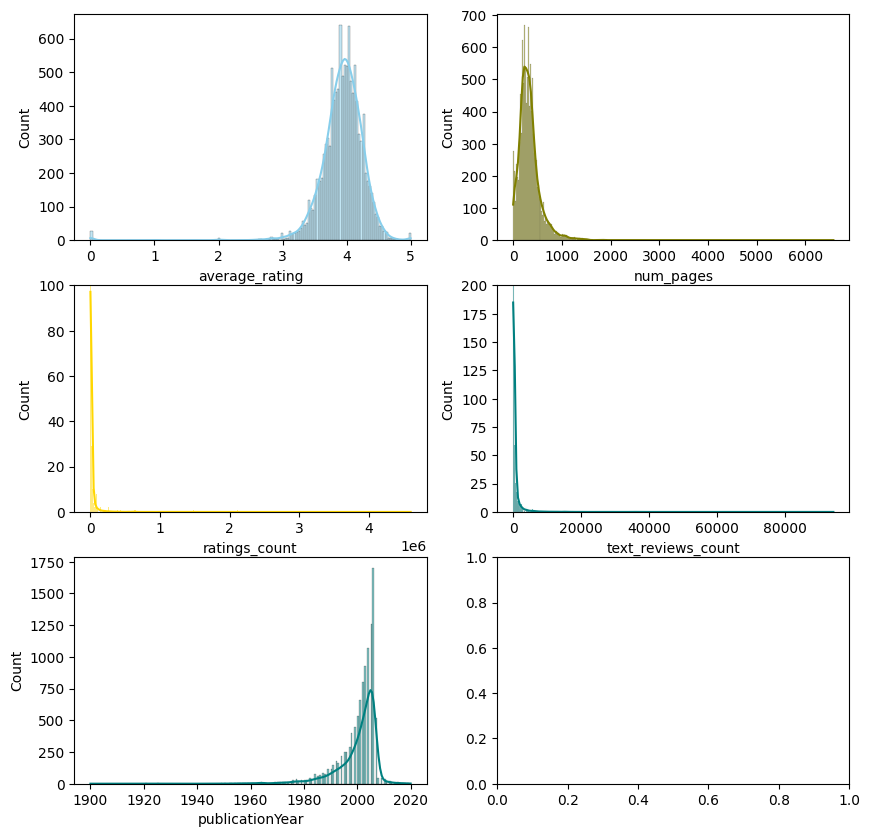

In [23]:
#df.select_dtypes(["float64","int64","int32"]).hist(figsize=(10, 10), bins=20)
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

sns.histplot(data=df, x="average_rating", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="num_pages", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="ratings_count", kde=True, color="gold", ax=axs[1, 0]).set_ylim(0, 100)
sns.histplot(data=df, x="text_reviews_count", kde=True, color="teal", ax=axs[1, 1]).set_ylim(0, 200)
sns.histplot(data=df, x="publicationYear", kde=True, color="teal", ax=axs[2, 0])

plt.show()

##### Histogram for the 'average_rating' by 'language_code_grouped'

<Axes: xlabel='average_rating', ylabel='Count'>

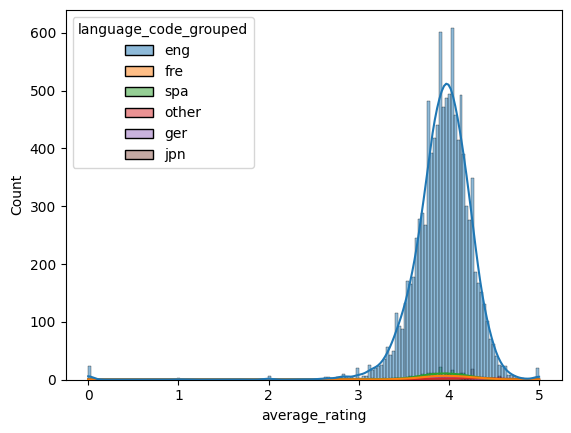

In [24]:
sns.histplot(data=df, x="average_rating", kde=True,hue='language_code_grouped')

##### Boxplot

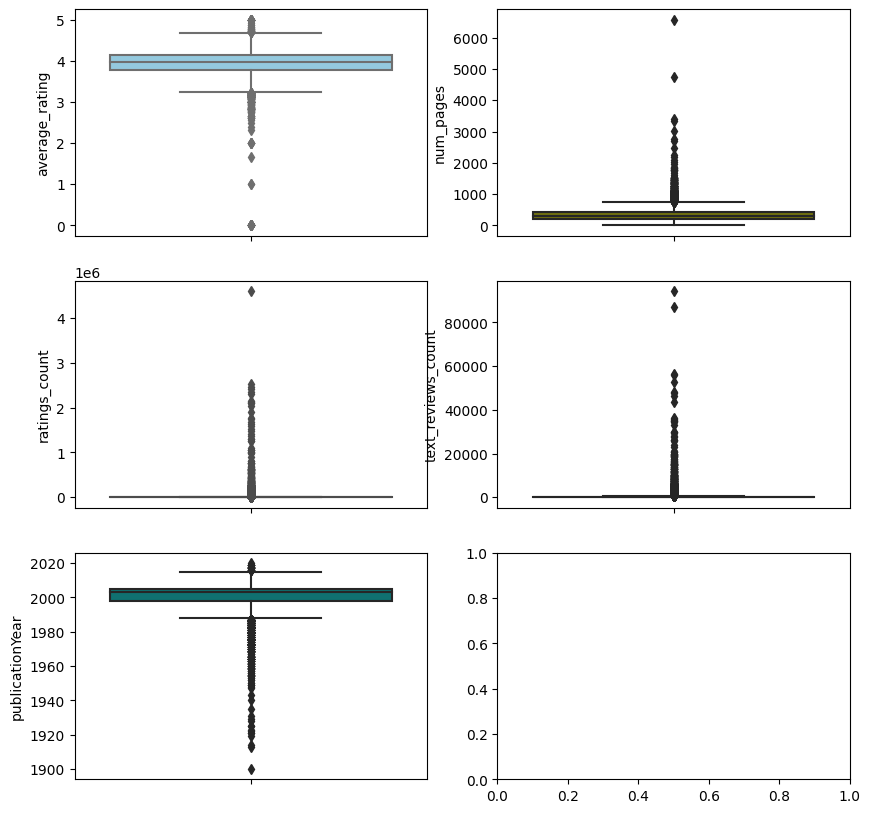

In [25]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

sns.boxplot(data=df, y="average_rating", color="skyblue", ax=axs[0, 0]) #fill=False, 
sns.boxplot(data=df, y="num_pages", color="olive", ax=axs[0, 1])
sns.boxplot(data=df, y="ratings_count", color="gold", ax=axs[1, 0])#.set_ylim(0, 100)
sns.boxplot(data=df, y="text_reviews_count", color="teal", ax=axs[1, 1])#.set_ylim(0, 200)
sns.boxplot(data=df, y="publicationYear", color="teal", ax=axs[2, 0])

plt.show()

##### Boxplot for the 'average_rating' by 'language_code_grouped'

<Axes: xlabel='language_code_grouped', ylabel='average_rating'>

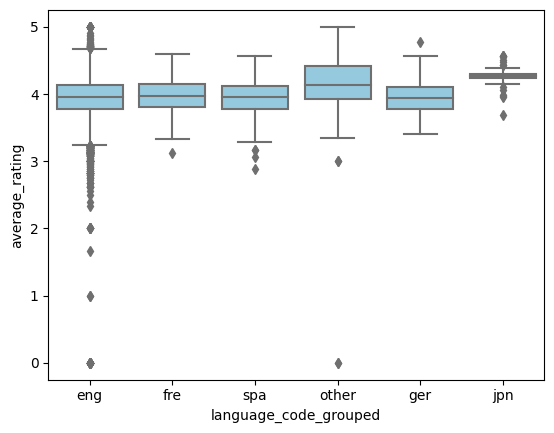

In [26]:
sns.boxplot(data=df, x="language_code_grouped", y="average_rating", color="skyblue")

In [27]:
fig = px.box(df, x="language_code_grouped", y="average_rating", points="all")
fig.show()

##### Correlation matrix

<Axes: >

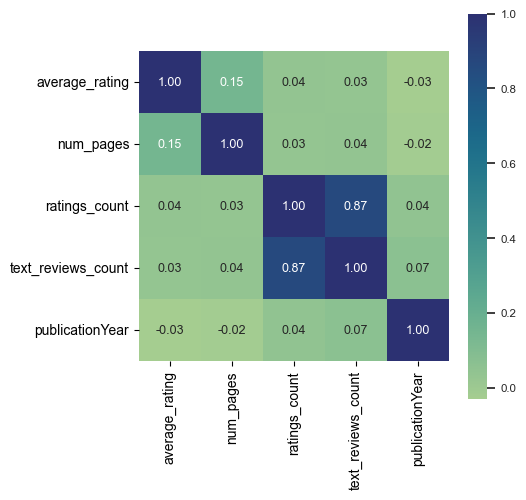

In [28]:
mcorrel = df.select_dtypes(["float64","int64","int32"]).corr(method="pearson")

fig, ax = plt.subplots(figsize=(5, 5))
sns.set(font_scale=0.75)
sns.heatmap(
    mcorrel,
    square=True,
    ax=ax,
    cmap="crest",
    annot=True, fmt=".2f"
)

###### High correlation between ratings_count and text_reviews_count which makes sense as we can expect that when a text has been reviewed, a rate has most probably be provided as well. This also mean that we can keep only one of these two columns for modeling. Many correlations are very low. Therefore, we could expect poor results from linear models (regression problem). 

##### Authors and publisher columns

###### After reviewing the variables and seeing that only a few are available, a treatment is sought for 'authors' and 'publisher' to see if it is possible to include it in the analysis.

In [29]:
#Number of unique authors
print(len(df['authors'].unique()))

#Authors sorted by the number of books written
tempDf = df[['authors','title']].groupby(['authors'])['authors'] \
    .count() \
        .reset_index(name='count') \
            .sort_values(['count'], ascending=False) \
            #.head(100)
tempDf

6643


,authors,count
4750,P.G. Wodehouse,40
5790,Stephen King,40
5473,Rumiko Takahashi,39
4714,Orson Scott Card,35
46,Agatha Christie,33
...,...,...
812,Carolyn Keene/Mildred Benson,1
3066,Joanna Weaver,1
3065,Joanna Strange,1
3064,Joan Sinclair/James Farrer,1


In [30]:
#Most (at least 75%) of authors have actually written only 1 book
print(tempDf.describe())

             count
count  6643.000000
mean      1.674996
std       2.280117
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max      40.000000


<Axes: >

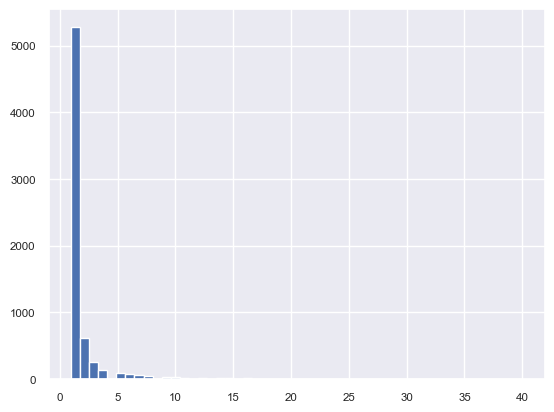

In [31]:
#Histogramme for number of authors depending on number of publications
tempDf['count'].hist(bins=50)

array([[<Axes: title={'center': 'count'}>]], dtype=object)

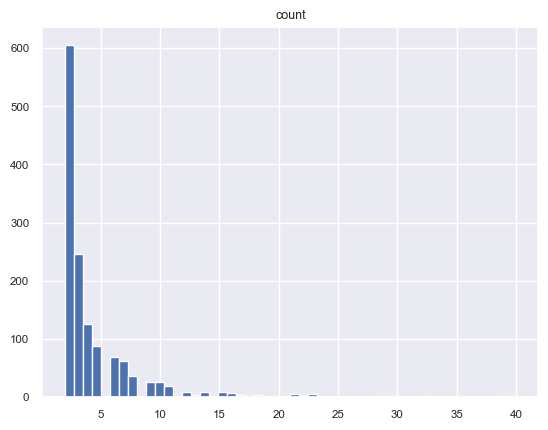

In [32]:
#Histogramme for number of authors depending on number of publications, when they have written more than 1 book
tempDf[tempDf['count'] > 1].hist(bins=50)

       mean_average_rating
count          5282.000000
mean              3.924335
std               0.403375
min               0.000000
25%               3.770000
50%               3.960000
75%               4.140000
max               5.000000
[[<Axes: title={'center': 'mean_average_rating'}>]]


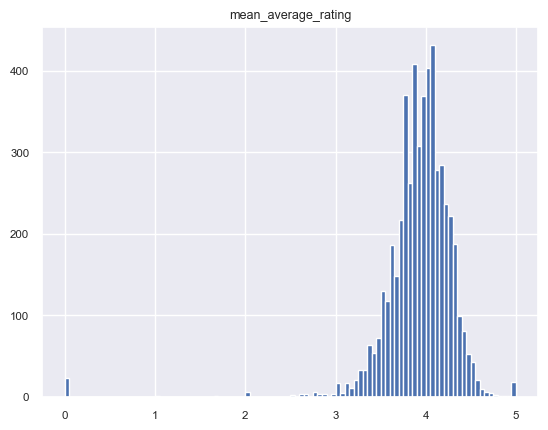

In [33]:
#When we look at how ratings are distributed amoung authors having only one book
#we can see that the ratings are more or less symetrically distributed around the mean (close to the median).

temp = df.copy()
temp2 = temp[['authors','average_rating']].groupby('authors') \
    .agg({'authors':'size', 'average_rating':'mean'}) \
    .rename(columns={'authors':'count','average_rating':'mean_average_rating'}) \

temp2 = temp2[temp2['count']==1][["mean_average_rating"]]
print(temp2.describe())
print(temp2.hist(bins=100))

<Axes: xlabel='count', ylabel='mean_average_rating'>

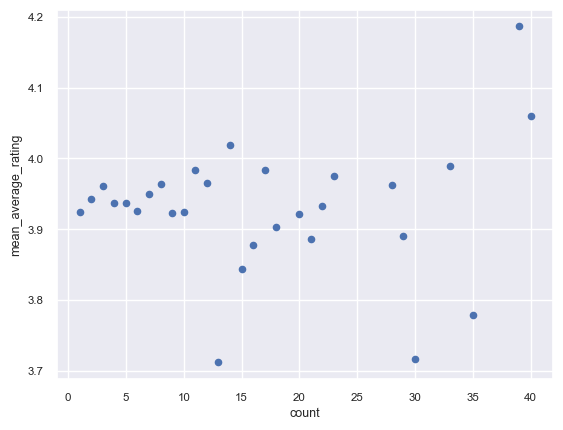

In [34]:
#We could think about creating a new column with the mean or median as an average rate
#However by looking at other number of publications by author, an obvious relation does not seem to be present.
#At least, there is not obvious linear relation
#For exemple, authors having more books in the dataset have not necessary a higher average rating.
temp = df.copy()
temp2 = temp[['authors','average_rating']].groupby('authors') \
    .agg({'authors':'size', 'average_rating':'mean'}) \
    .rename(columns={'authors':'count','average_rating':'mean_average_rating'}) \

temp2 = temp2.groupby('count') \
    .agg({'mean_average_rating':'mean'})
temp2.reset_index().plot(kind='scatter', x='count', y='mean_average_rating')

<bound method NDFrame.head of                                count  mean_average_rating
publisher                                                
10/18                              2             3.650000
1st Book Library                   1             3.580000
1st World Library                  1             4.180000
A & C Black (Childrens books)      1             4.400000
A Harvest Book/Harcourt  Inc.      1             4.070000
...                              ...                  ...
聯經出版事業股份有限公司                       2             4.400000
英文漢聲出版股份有限公司                       1             4.220000
角川書店 (Kadokawa Shoten)             2             3.815000
講談社                                6             4.283333
集英社                               12             4.237500

[2292 rows x 2 columns]>


<Axes: xlabel='count', ylabel='mean_average_rating'>

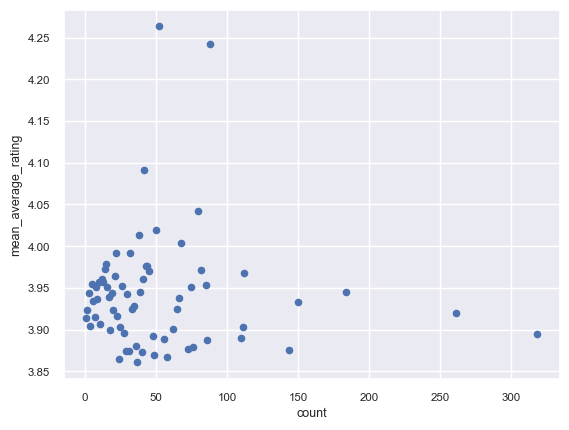

In [35]:
#It seems to be similar for the publishers
temp2 = temp[['publisher','average_rating']].groupby('publisher') \
    .agg({'publisher':'size', 'average_rating':'mean'}) \
    .rename(columns={'publisher':'count','average_rating':'mean_average_rating'}) \

print(temp2.head)

temp2 = temp2.groupby('count') \
    .agg({'mean_average_rating':'mean'})
result = pd.concat([df, temp2], axis=1, join="inner")

temp2.reset_index().plot(kind='scatter', x='count', y='mean_average_rating')

       author_number_books  author_books_avg_rating  author_ratings_count
count          6643.000000              6643.000000          6.643000e+03
mean              1.674996                 3.928449          3.004342e+04
std               2.280117                 0.381025          2.043289e+05
min               1.000000                 0.000000          0.000000e+00
25%               1.000000                 3.780000          8.200000e+01
50%               1.000000                 3.960000          5.650000e+02
75%               1.000000                 4.130000          4.787500e+03
max              40.000000                 5.000000          8.923980e+06


<Axes: >

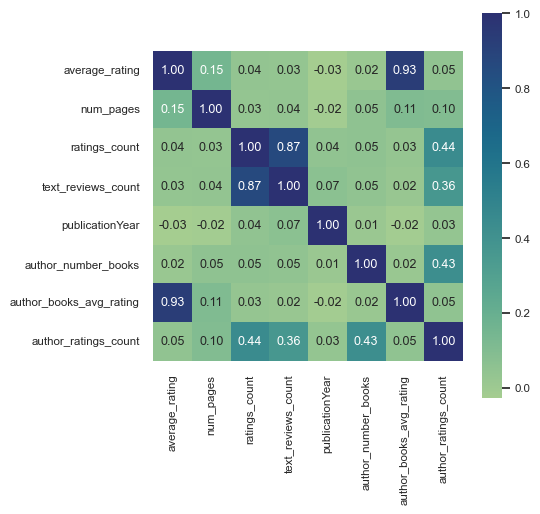

In [36]:
#how could we still add information embedded in the authors dimension ?
#There are thousands of unique authors. Therefore, hot encoding of all authors would not be appropriate.
#Therefore, we can try do add take into account information related to the author by using indirect related KPIs
#For example author_ratings_count or author_number_books

#create the KPIs columns
authorsEmbededInfo = df[['authors','average_rating','ratings_count']].groupby('authors').agg({'authors':'size', 'average_rating':'mean','ratings_count':'sum'}).rename(columns={'authors':'author_number_books','average_rating':'author_books_avg_rating','ratings_count':'author_ratings_count'})
authorsEmbededInfo = authorsEmbededInfo.reset_index()

print(authorsEmbededInfo.describe())
#authorsEmbededInfo

#Add the new created columns into the dataset, in order to take into account information embeded in 'authors'
df = pd.merge(df, authorsEmbededInfo, on='authors')

#Let's see the new correlation matrix
#High correlation between author_books_avg_rating and average_rating because it has been constructed on it for analysis purpose. It will not be used for modeling.
mcorrel = df.select_dtypes(["float64","int64","int32"]).corr(method="pearson")

fig, ax = plt.subplots(figsize=(5, 5))
sns.set(font_scale=0.75)
sns.heatmap(
    mcorrel,
    square=True,
    ax=ax,
    cmap="crest",
    annot=True, fmt=".2f"
)

#Let's also look at again the new pair relations

#col = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
#        'publicationYear','author_number_books','author_books_avg_rating','author_ratings_count',"catRating"]

#sns.pairplot(df[col],hue="catRating", corner=True) 

array([[<Axes: title={'center': 'author_number_books'}>,
        <Axes: title={'center': 'author_books_avg_rating'}>]],
      dtype=object)

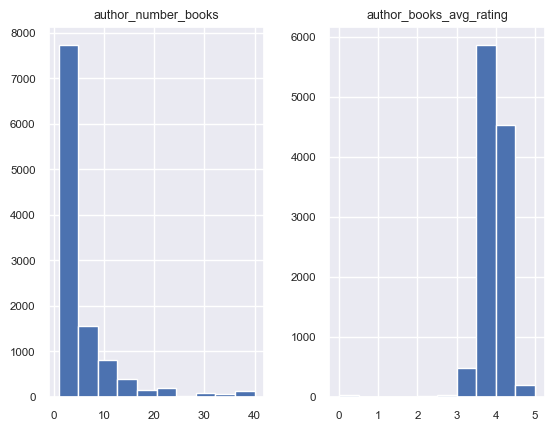

In [37]:
df[['author_number_books','author_books_avg_rating']].hist()

#### Categorizing the variable to be predicted 

###### An interesting exercise would be the prediction of the 'average_rating' but categorized into two groups, one for the highest scores and the other for its complement. The variable was previously categorized, and some graphs are shown below for a visual analysis of the possible relationships with the predictor variables.

c:\Users\datas\DSTI_2324\PythonMLProject\PythonMLProj\.venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



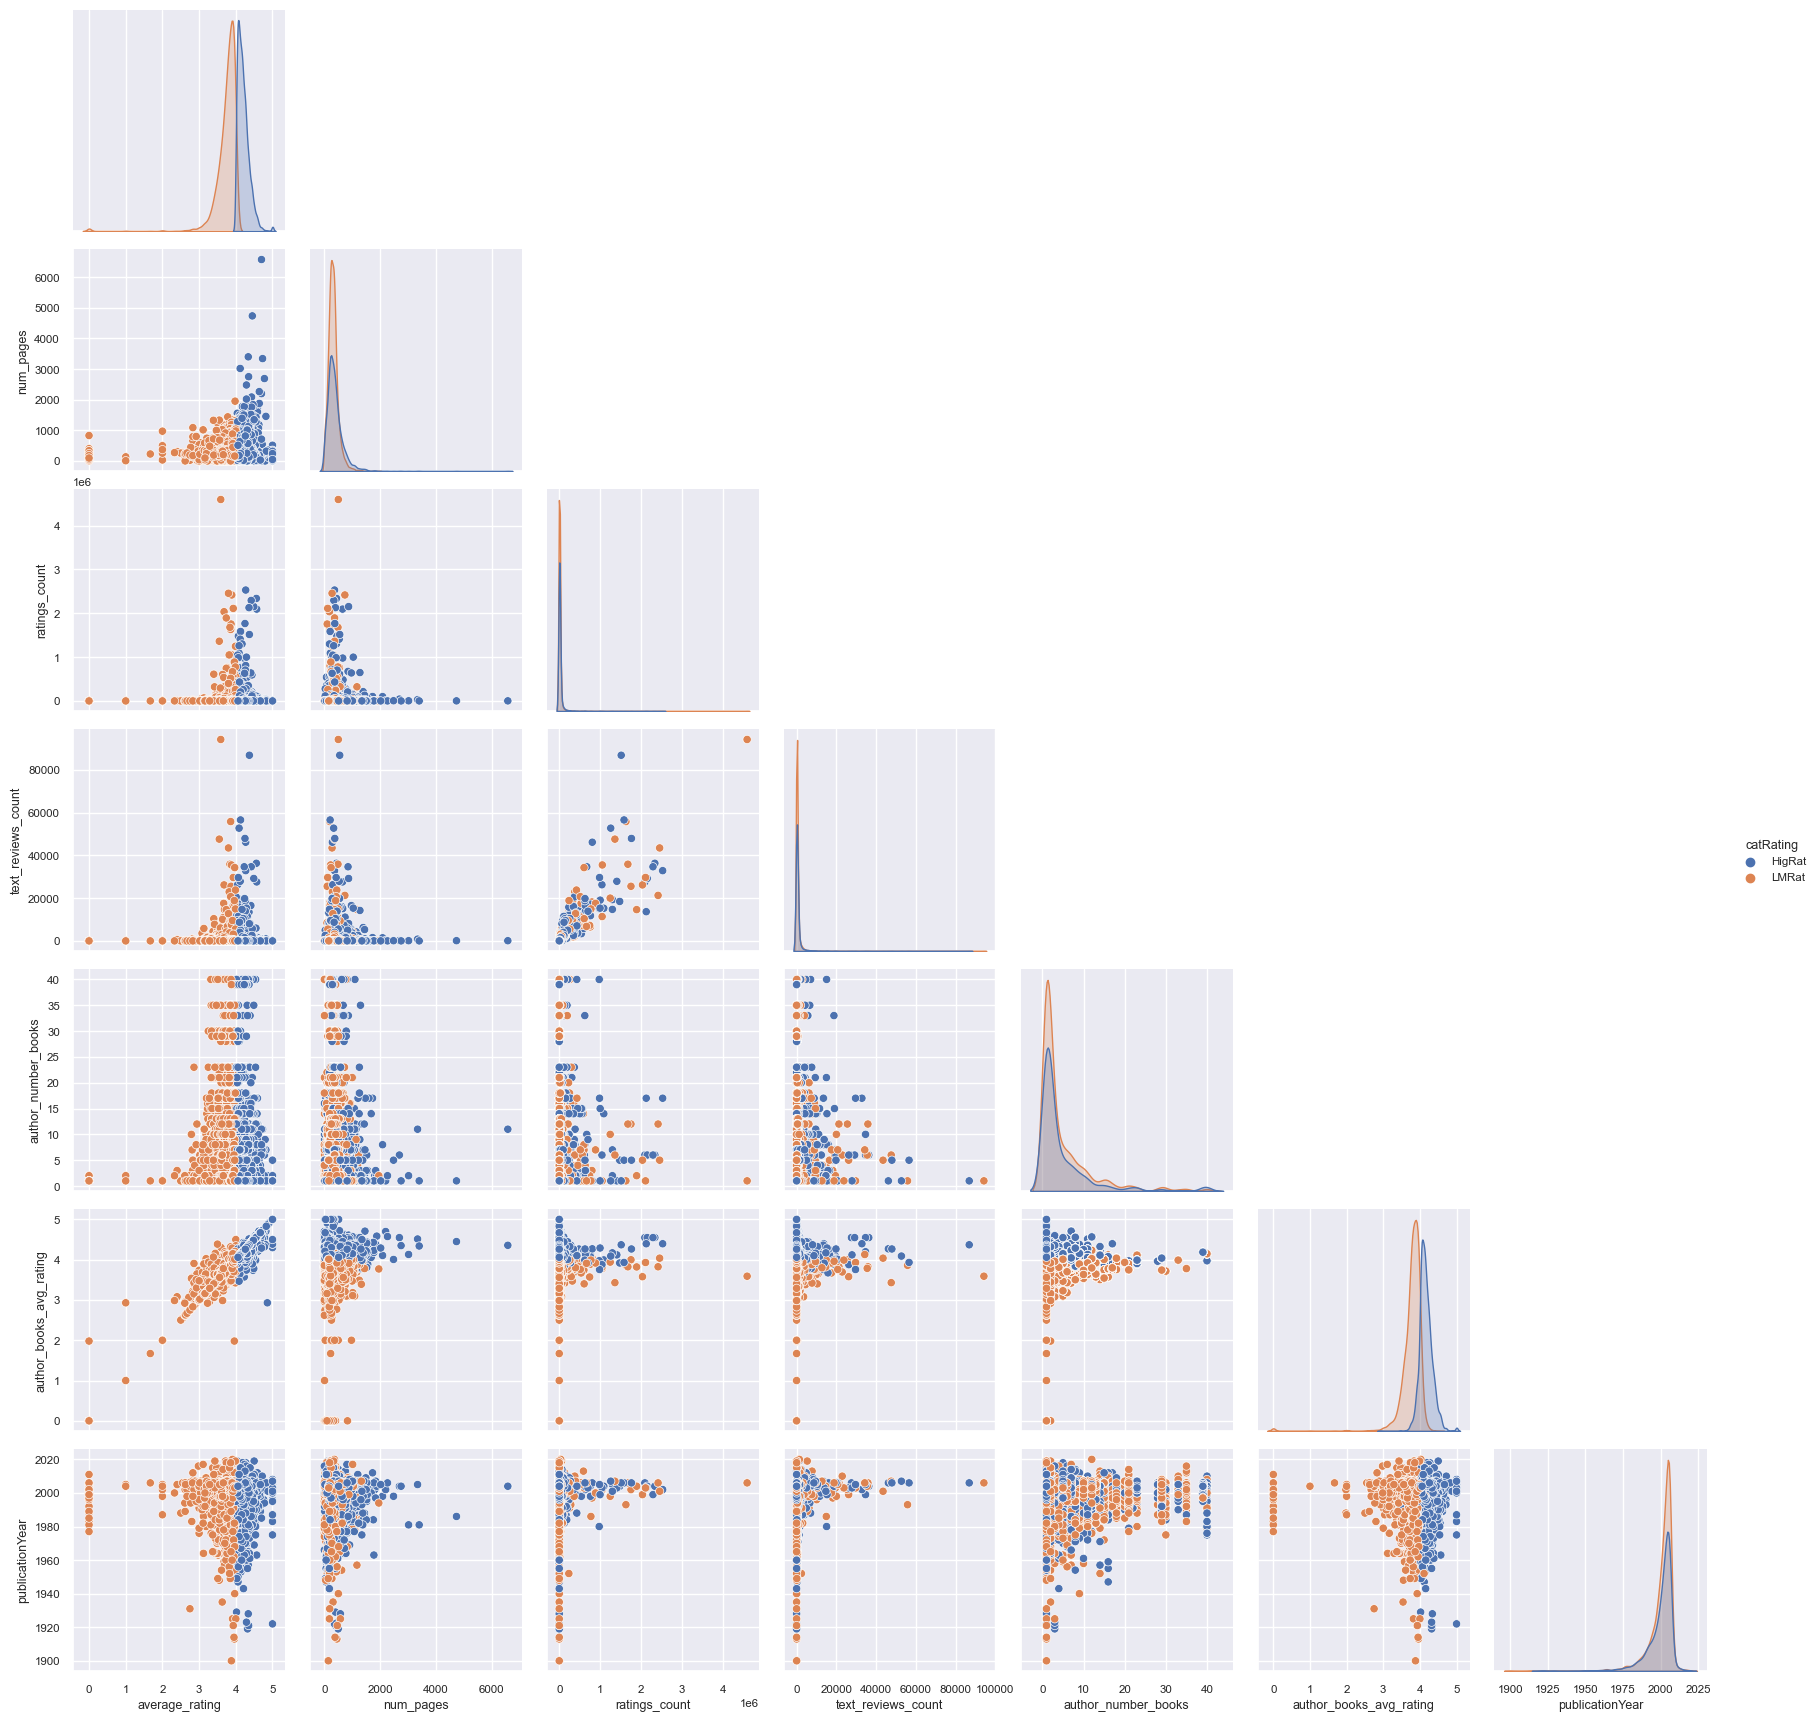

In [38]:
col = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',"author_number_books",
        'author_books_avg_rating','publicationYear',"catRating"]

sns.pairplot(df[col],hue="catRating", corner=True) 

## III. Modeling

### 3.1 Modeling - Preprocessing

In [39]:
 #Data of interest 
col = ['num_pages', 'text_reviews_count', "author_number_books",
        'publicationYear','language_code_grouped', 'catRating','average_rating']

dfmodel = df[col].copy()

#### 3.1.1 Handle outliers

In [40]:
#%%outliers

#The process of identifying outliers has many names in data mining and machine 
# learning such as outlier mining, outlier modeling and novelty detection and 
# anomaly detection.In his book "Outlier Analysis", Aggarwal provides a useful taxonomy
#  of outlier detection methods.

#one possibility:Delimit the variables using 3 standard deviations

columns =['num_pages','text_reviews_count', "author_number_books"] #'ratings_count',

for c in columns:
    data_mean, data_std = np.mean(dfmodel[c]), np.std(dfmodel[c])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    dfmodel[c]= [upper if x > upper else x for x in df[c]]

dfmodel.describe()

,num_pages,text_reviews_count,author_number_books,publicationYear,average_rating
count,11127.000000,11127.000000,11127.000000,11127.000000,11127.000000
mean,331.004626,426.618096,4.528823,2000.167520,3.933631
std,206.766439,1199.900322,5.747504,8.248836,0.352445
min,0.000000,0.000000,1.000000,1900.000000,0.000000
25%,192.000000,9.000000,1.000000,1998.000000,3.770000
50%,299.000000,46.000000,2.000000,2003.000000,3.960000
75%,416.000000,237.500000,6.000000,2005.000000,4.135000
max,1059.726331,8270.037027,25.162412,2020.000000,5.000000


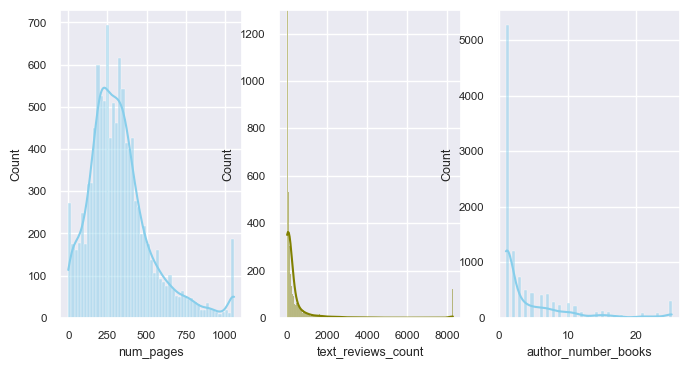

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))
sns.histplot(data=dfmodel, x="num_pages", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=dfmodel, x="text_reviews_count", kde=True, color="olive", ax=axs[1]).set_ylim(0, 1300)
sns.histplot(data=dfmodel, x="author_number_books", kde=True, color="skyblue", ax=axs[2])
plt.show()

#### 3.1.2 Preprocessing for categorical case 

##### Rename categories

In [42]:
# Apply the function, to rename categories

dicCat = {"HigRat": "1",
        "LMRat": "0"}

dfmodel["catRating"] = dfmodel["catRating"].apply(lambda x: dicCat[x])


##### Split data and transform features

In [43]:
X = dfmodel[['num_pages', 'text_reviews_count', 'publicationYear','language_code_grouped','author_number_books']]
y = dfmodel.loc[:, "catRating"]

#split the data
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y, train_size=0.8, random_state=1, stratify=y
)

##### Encode target column

In [44]:
#Encode target column
label_encode = LabelEncoder()
label_encode.fit(y_train_cat)
y_train_cat = label_encode.transform(y_train_cat)
y_test_cat = label_encode.transform(y_test_cat)

In [45]:
#Compare samples
print(X_train_cat.describe())
print(X_test_cat.describe())

         num_pages  text_reviews_count  publicationYear  author_number_books
count  8901.000000         8901.000000      8901.000000          8901.000000
mean    330.223607          423.676054      2000.223346             4.553306
std     205.284459         1190.843360         8.166305             5.756700
min       0.000000            0.000000      1913.000000             1.000000
25%     194.000000            9.000000      1998.000000             1.000000
50%     299.000000           48.000000      2003.000000             2.000000
75%     416.000000          237.000000      2005.000000             6.000000
max    1059.726331         8270.037027      2020.000000            25.162412
         num_pages  text_reviews_count  publicationYear  author_number_books
count  2226.000000         2226.000000      2226.000000          2226.000000
mean    334.127650          438.382300      1999.944295             4.430922
std     212.607575         1235.656215         8.569166             5.710824

##### Apply transformations

In [46]:
cont_ix = X_train_cat.select_dtypes(exclude=["object"]).columns
cat_ix = X_train_cat.select_dtypes(include=["object"]).columns
print(cont_ix)
print(cat_ix)

cont_pipeline = make_pipeline(
    RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0)),
    PowerTransformer(method="yeo-johnson")
)

cat_pipeline = make_pipeline(OneHotEncoder(drop="first"))

preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_pipeline, cont_ix),
        ("cat", cat_pipeline, cat_ix),
    ]
)

dt = Pipeline(steps=[("preprocessor", preprocessor)])
dt.fit(X_train_cat)

X_train_cat_dt = dt.transform(X_train_cat)

#Final data set
var_list = list(dt.get_feature_names_out())
X_train_cat = pd.DataFrame(X_train_cat_dt, columns=var_list)

X_test_cat_dt = dt.transform(X_test_cat)
X_test_cat = pd.DataFrame(X_test_cat_dt, columns=var_list)

Index(['num_pages', 'text_reviews_count', 'publicationYear',
       'author_number_books'],
      dtype='object')
Index(['language_code_grouped'], dtype='object')


array([[<Axes: title={'center': 'cont__num_pages'}>,
        <Axes: title={'center': 'cont__text_reviews_count'}>],
       [<Axes: title={'center': 'cont__publicationYear'}>,
        <Axes: title={'center': 'cont__author_number_books'}>]],
      dtype=object)

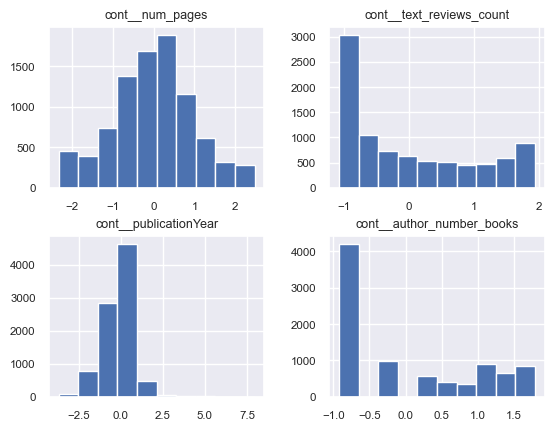

In [47]:
#Transforming the data improve the shape but not to the point of a normal one
X_train_cat[['cont__num_pages','cont__text_reviews_count','cont__publicationYear','cont__author_number_books']].hist()

#### 3.1.3 Preprocessing for regression case

##### Split data and transform features

In [48]:
yCont = dfmodel.loc[:, "average_rating"]

#split the data
X_train, X_test, yCont_train, yCont_test = train_test_split(
   X, yCont, train_size=0.8, random_state=1
)

print(yCont.describe())
print(yCont_train.describe())
print(yCont_test.describe())

count    11127.000000
mean         3.933631
std          0.352445
min          0.000000
25%          3.770000
50%          3.960000
75%          4.135000
max          5.000000
Name: average_rating, dtype: float64
count    8901.000000
mean        3.934547
std         0.350124
min         0.000000
25%         3.770000
50%         3.960000
75%         4.130000
max         5.000000
Name: average_rating, dtype: float64
count    2226.000000
mean        3.929969
std         0.361635
min         0.000000
25%         3.770000
50%         3.960000
75%         4.140000
max         5.000000
Name: average_rating, dtype: float64


##### Apply transformations

In [49]:
cont_ix = X_train.select_dtypes(exclude=["object"]).columns
cat_ix = X_train.select_dtypes(include=["object"]).columns

dt_cont = Pipeline(steps=[("preprocessor", preprocessor)])
dt_cont.fit(X_train)

X_train_dt = dt_cont.transform(X_train)

#Final data set
var_list = list(dt_cont.get_feature_names_out())
X_train = pd.DataFrame(X_train_dt, columns=var_list)

X_test_dt = dt_cont.transform(X_test)
X_test = pd.DataFrame(X_test_dt, columns=var_list)

### 3.2 Modeling - Regression

In [50]:
#Modeling - Polynomial Regression
# the default "include_bias=True" adds a feature that's constantly 1
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
X_poly_train = poly.transform(X_train)
X_poly_test = poly.transform(X_test)

print("X.shape: {}".format(X.shape))
print("X_train.shape: {}".format(X_train.shape))
print("X_poly_train.shape: {}".format(X_poly_train.shape))
print("Entries of X:\n{}".format(X[:5]))
print("Entries of X_train:\n{}".format(X_train[:5]))
print("Entries of X_poly_train:\n{}".format(X_poly_train[:5]))
print("Polynomial feature names:\n{}".format(poly.get_feature_names_out()))

X.shape: (11127, 5)
X_train.shape: (8901, 9)
X_poly_train.shape: (8901, 54)
Entries of X:
     num_pages  text_reviews_count  publicationYear language_code_grouped  \
0   652.000000         8270.037027             2006                   eng   
1   870.000000         8270.037027             2004                   eng   
2   435.000000         8270.037027             2004                   eng   
3  1059.726331          164.000000             2004                   eng   
4   341.000000         8270.037027             1999                   eng   

   author_number_books  
0                  6.0  
1                  6.0  
2                  6.0  
3                  6.0  
4                  6.0  
Entries of X_train:
   cont__num_pages  cont__text_reviews_count  cont__publicationYear  \
0         0.238898                 -1.050319              -0.024742   
1         0.139867                  0.476154              -0.935734   
2        -0.319860                  0.333445               1.223

[0.02393066 0.01988276 0.02228013 0.02115952 0.01761739]
LinR: 0.020974 (0.002142)
[-0.04741277 -0.04465007 -0.03501032 -0.0401217  -0.08350088]
KNN: -0.050139 (0.017203)
[0.02385535 0.01981513 0.02225575 0.0213503  0.01766639]
RGE: 0.020989 (0.002115)
[0.02269719 0.01910767 0.0218233  0.02234457 0.01757179]
RGE10: 0.020709 (0.002014)
[0.02392422 0.01987625 0.0222781  0.02117972 0.01762323]
RGE01: 0.020976 (0.002139)
[-2.06993374e-04 -1.17228086e-04 -9.00959697e-04 -7.99417689e-05
 -1.39201981e-03]
LSO: -0.000539 (0.000521)
[0.01103629 0.01063267 0.01343181 0.01844524 0.01418103]
LSO001: 0.013545 (0.002800)
[0.02346384 0.01974348 0.02214664 0.02163801 0.01776116]
LSO00001: 0.020951 (0.001992)
[0.02393066 0.01988276 0.02228013 0.02115952 0.01761739]
polyLR: 0.020974 (0.002142)
[0.01851733 0.01104385 0.01457438 0.01372837 0.01632252]
LSVR: 0.014837 (0.002507)
[0.03766372 0.04228966 0.03398925 0.05628225 0.05073157]
RFReg: 0.044191 (0.008237)


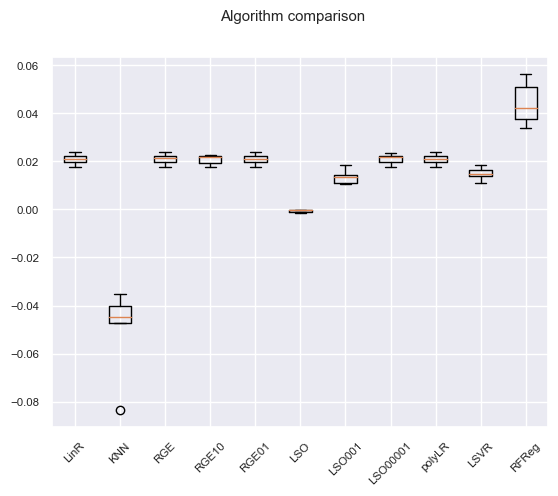

In [51]:
#Model comparison
models = []
models.append(("LinR", LinearRegression()))
models.append(("KNN", KNeighborsRegressor (n_neighbors=7)))
models.append(("RGE", Ridge(alpha=1)))
models.append(("RGE10", Ridge(alpha=10)))
models.append(("RGE01", Ridge(alpha=0.1)))
models.append(("LSO", Lasso(alpha=1)))
models.append(("LSO001", Lasso(alpha=0.01, max_iter=100000)))
models.append(("LSO00001", Lasso(alpha=0.0001, max_iter=100000)))
models.append(("polyLR", LinearRegression()))
models.append(("LSVR", LinearSVR(max_iter=2000)))
models.append(("RFReg", RandomForestRegressor(max_depth=2, random_state=0)))

results = []
names = []


for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    if name=='polyLinreg':
        cv_results = cross_val_score(
        model, X_poly_train, yCont_train, cv=kfold, n_jobs=-1
        )
    else:
        cv_results = cross_val_score(
        model, X_train, yCont_train, cv=kfold,  n_jobs=-1
        )
    print(cv_results)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot to compare
fig = plt.figure()
fig.suptitle("Algorithm comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45)
plt.show()

###### As expected above, regression Modeling do not perform well, even if we add some non linearity in the modeling (e.g. polynomial linear regression, etc)
###### Test score being really worst comparing to train score in most of the cases :

In [52]:
#Modeling - Linear regression model
linReg = LinearRegression().fit(X_train, yCont_train)
print("Linear Training set score: {:.3f}".format(linReg.score(X_train,yCont_train)))
print("Linear Test set score: {:.3f}".format(linReg.score(X_test,yCont_test)))

Linear Training set score: 0.023
Linear Test set score: 0.006


In [53]:
#Modeling - KNN regression model
KNN = KNeighborsRegressor (n_neighbors=7)
KNN.fit(X_train, yCont_train)
print("Linear Training set score: {:.3f}".format(KNN.score(X_train,yCont_train)))
print("Linear Test set score: {:.3f}".format(KNN.score(X_test,yCont_test)))

Linear Training set score: 0.216
Linear Test set score: 0.003


In [54]:
#Modeling - Ridge Linear Regression
ridge= Ridge().fit(X_train, yCont_train)
print("Ridge with alpha=1")
print("Training set score: {:.2f}".format(ridge.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, yCont_test)))

print("\nRidge with alpha=10")
ridge10= Ridge(alpha=10).fit(X_train, yCont_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, yCont_test)))

ridge01= Ridge(alpha=0.1).fit(X_train, yCont_train)
print("\nRidge with alpha=0.1")
print("Training set score: {:.2f}".format(ridge01.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, yCont_test)))

Ridge with alpha=1
Training set score: 0.02
Test set score: 0.01

Ridge with alpha=10
Training set score: 0.02
Test set score: 0.01

Ridge with alpha=0.1
Training set score: 0.02
Test set score: 0.01


In [55]:
#Modeling - Lasso Linear Regression (Least Absolute Shrinkage And Selection Operator)
lasso = Lasso().fit(X_train, yCont_train)
print("Lasso with alpha=1")
print("Training set score: {:.2f}".format(lasso.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, yCont_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ !=0)))

#Lasso with less regularisation
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, yCont_train)
print("\nLasso with alpha=0.01")
print("Training set score: {:.2f}".format(lasso001.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, yCont_test)))
print("Number of features used: {}".format(np.sum(lasso001.coef_ !=0)))

#Lasso with even less regularisation
lasso00001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, yCont_train)
print("\nLasso with alpha=0.0001")
print("Training set score: {:.2f}".format(lasso00001.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(lasso00001.score(X_test, yCont_test)))
print("Number of features used: {}".format(np.sum(lasso00001.coef_ !=0)))

Lasso with alpha=1
Training set score: 0.00
Test set score: -0.00
Number of features used: 0

Lasso with alpha=0.01
Training set score: 0.01
Test set score: 0.01
Number of features used: 2

Lasso with alpha=0.0001
Training set score: 0.02
Test set score: 0.01
Number of features used: 9


In [56]:
poly_linreg = LinearRegression().fit(X_poly_train, yCont_train)
print("Poly Training set score: {:.3f}".format(poly_linreg.score(X_poly_train,yCont_train)))
print("Poly Test set score: {:.3f}".format(poly_linreg.score(X_poly_test,yCont_test)))

Poly Training set score: 0.058
Poly Test set score: 0.052


In [57]:
linSVR = LinearSVR(max_iter=2000)
linSVR.fit(X_train, yCont_train)
print("SGD linear regressor Training set score: {:.3f}".format(linSVR.score(X_train,yCont_train)))
print("SGD linear regressor Test set score: {:.3f}".format(linSVR.score(X_test,yCont_test)))

c:\Users\datas\DSTI_2324\PythonMLProject\PythonMLProj\.venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



SGD linear regressor Training set score: 0.017
SGD linear regressor Test set score: -0.001


In [58]:
RFReg = RandomForestRegressor(max_depth=2, random_state=0)
RFReg.fit(X_train, yCont_train)
print("Random Forest regressor Training set score: {:.3f}".format(RFReg.score(X_train,yCont_train)))
print("Random Forest regressor Test set score: {:.3f}".format(RFReg.score(X_test,yCont_test)))

Random Forest regressor Training set score: 0.049
Random Forest regressor Test set score: 0.027


###### What if we use rather a smaller number of bins to for the average ratings values instead of using all single values, in order to try to improve the model performance !

###### To do that, we use the quartiles to built this bins in order to avoid un balanced bins.

array([[<Axes: title={'center': '0'}>]], dtype=object)

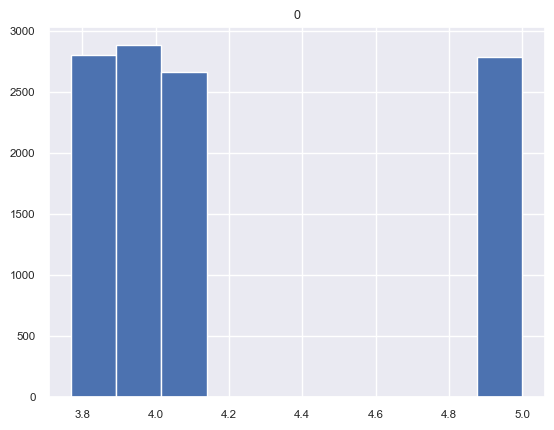

In [61]:
yCont = dfmodel.loc[:, "average_rating"]

quartile1 = yCont.quantile(0.25)
quartile2 = yCont.quantile(0.5)
quartile3 = yCont.quantile(0.75)
yContMax = yCont.max()

yCont = [quartile1 if i <= quartile1 else i for i in yCont]
yCont = [quartile2 if (i > quartile1 and i <= quartile2) else i for i in yCont]
yCont = [quartile3 if (i > quartile2 and i <= quartile3) else i for i in yCont]
yCont = [yContMax if (i > quartile3) else i for i in yCont]
yCont = pd.DataFrame(yCont)

yCont.hist(bins=10)

In [62]:
#split the data
X_train, X_test, yCont_train, yCont_test = train_test_split(
   X, yCont, train_size=0.8, random_state=1
)

print(yCont.describe())
print(yCont_train.describe())
print(yCont_test.describe())

                  0
count  11127.000000
mean       4.214046
std        0.471505
min        3.770000
25%        3.770000
50%        3.960000
75%        4.567500
max        5.000000
                 0
count  8901.000000
mean      4.213101
std       0.470617
min       3.770000
25%       3.770000
50%       3.960000
75%       4.135000
max       5.000000
                 0
count  2226.000000
mean      4.217821
std       0.475125
min       3.770000
25%       3.770000
50%       3.960000
75%       5.000000
max       5.000000


##### Apply transformations

In [64]:
#Final data set
X_train = pd.DataFrame(X_train_dt, columns=var_list)

X_test_dt = dt_cont.transform(X_test)
X_test = pd.DataFrame(X_test_dt, columns=var_list)

[0.02655434 0.01982985 0.0301085  0.0190138  0.01983461]
LinR: 0.023068 (0.004452)
[-0.04381303 -0.00651568 -0.04613657  0.00778445 -0.00679425]
KNN: -0.019095 (0.021791)
[0.02619333 0.01972867 0.02996487 0.01940104 0.02009162]
RGE: 0.023076 (0.004261)
[0.02293886 0.0186127  0.02857179 0.02129288 0.02102534]
RGE10: 0.022488 (0.003341)
[0.02651883 0.01982021 0.03009446 0.01905502 0.01986257]
RGE01: 0.023070 (0.004432)
[-2.65631319e-05 -2.62502505e-04 -1.14286073e-03 -2.73589451e-04
 -7.46560337e-04]
LSO: -0.000490 (0.000401)
[0.00681665 0.00866411 0.01386738 0.01638832 0.01310391]
LSO001: 0.011768 (0.003513)
[0.02606203 0.019589   0.02997497 0.01962885 0.02005895]
LSO00001: 0.023063 (0.004235)
[0.02655434 0.01982985 0.0301085  0.0190138  0.01983461]
polyLR: 0.023068 (0.004452)
[-0.10941689 -0.11883204 -0.09587712 -0.13735568 -0.16542048]
LSVR: -0.125380 (0.024144)
[0.03722626 0.04741794 0.04633189 0.04855516 0.06690902]
RFReg: 0.049288 (0.009683)


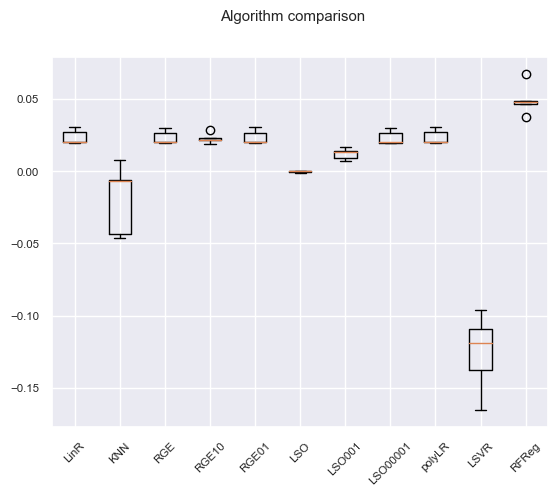

In [65]:
#Model comparison by using a balanced and smaller number of bins for the target

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    if name=='polyLinreg':
        cv_results = cross_val_score(
        model, X_poly_train, yCont_train, cv=kfold, n_jobs=-1
        )
    else:
        cv_results = cross_val_score(
        model, X_train, yCont_train, cv=kfold,  n_jobs=-1
        )
    print(cv_results)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot to compare
fig = plt.figure()
fig.suptitle("Algorithm comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45)
plt.show()

###### There are less variances on the results and the "less worst" model has better performances. However, it  does not change the fact that the results of regression models are not good.

###### Let explore the Classification models then.

### 3.3 Modeling - Classification 

##### Baseline

LR: 0.561322 (0.011224)
LDA: 0.561425 (0.011213)
KNN: 0.593066 (0.012115)
RF: 0.625246 (0.014062)
CART: 0.549279 (0.010270)
NB: 0.600516 (0.011156)
SVM: 0.612764 (0.011907)


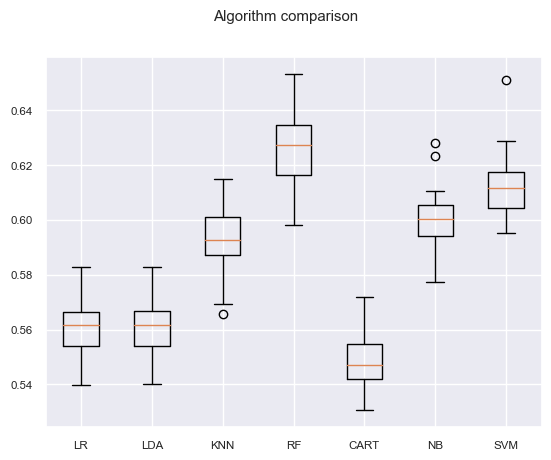

In [66]:
#base line
models = []
models.append(("LR", LogisticRegression(solver="lbfgs")))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("RF",RandomForestClassifier(n_estimators=100, random_state=1),))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
models.append(("SVM", SVC()))


results = []
names = []
scoring = "roc_auc"

for name, model in models:
    kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    cv_results = cross_val_score(
        model, X_train_cat, y_train_cat, cv=kfold, scoring=scoring, n_jobs=-1
    )
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot to compare
fig = plt.figure()
fig.suptitle("Algorithm comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

###### We get better results by using classification models. Repeated Stratified cross validation with different randomization in each repetition ends up with Random Forest and SVM as the best models.

#### 3.3.1 SVM - Classification 

##### We will tune the hyperparameters to see if it is possible to achieve better results in the two best methods and compare them.

In [69]:
#See also section 3.3.2 SVM - Classification - Enhance grid search for a better industrialization of the model
param_grid = {'C': [0.1,1], 'gamma': [1,0.1,0.01],'kernel': ['rbf', 'poly', 'sigmoid']}
#param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}



#hyperparameters
svm = SVC()

grid_randomSVMM = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_grid,
    #See also section 3.3.2 SVM - Classification - Enhance grid search for a better industrialization of the model
    n_iter=11,
    #n_iter=48,
    cv=5,
    verbose=2,
    random_state=50,
    n_jobs=-1,
)

grid_randomSVMM.fit(X_train_cat, y_train_cat)

print(grid_randomSVMM.best_estimator_)

#Fitting 5 folds for each of 48 candidates, totalling 240 fits
#SVC(C=1, gamma=1)


c:\Users\Stefanny\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 48 candidates, totalling 240 fits
SVC(C=1, gamma=1)


In [70]:
print("Corresponding best cross validations score is:\n{}\n".format(grid_randomSVMM.best_score_))

print("Corresponding Test sest score is:\n{}".format(grid_randomSVMM.score(X_test_cat, y_test_cat)))

Corresponding best cross validations score is:
0.6202687544555829

Corresponding Test sest score is:
0.6271338724168913


In [200]:
svm = SVC(C=1, gamma=1, probability=True)

svm.fit(X_train_cat, y_train_cat)
# prediccion
yhatsvm = svm.predict_proba(X_test_cat)

print(yhatsvm)

[[0.31 0.69]
 [0.32 0.68]
 [0.66 0.34]
 ...
 [0.65 0.35]
 [0.64 0.36]
 [0.64 0.36]]


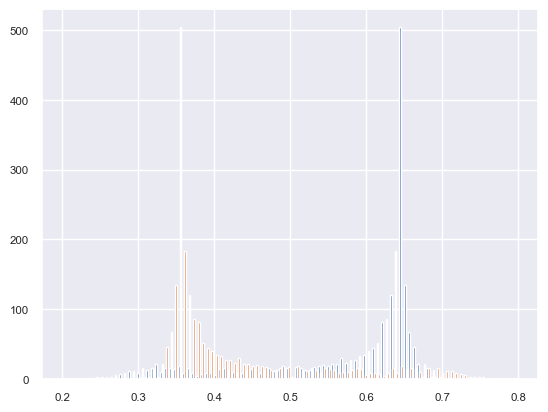

In [201]:
# Histogram of probabilities 
plt.hist(yhatsvm, bins=100)
plt.show()

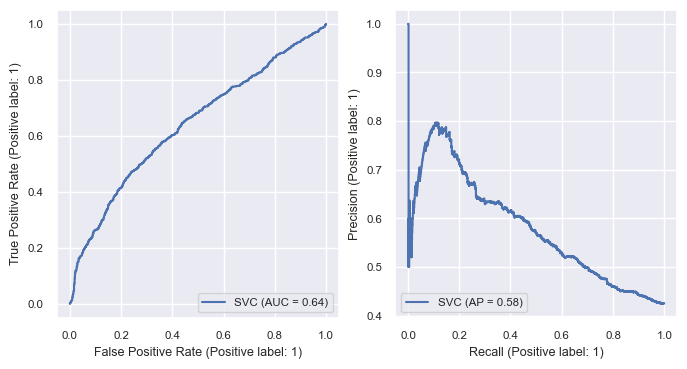

In [202]:
y_predSvm = yhatsvm[:, 1] #positive class predicted (probabilities)

roc_display = RocCurveDisplay.from_estimator(svm, X_test_cat, y_test_cat)
plt.close()
pr_display = PrecisionRecallDisplay.from_estimator(svm, X_test_cat, y_test_cat)
plt.close()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)

In [203]:
#function to define the variable in terms of category, based on a threshold.
def to_labels(ped,t):
    a = np.where(ped>t, 1, 0)
    return a

#potential thresholds
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold: F2-measure Less weight in precision, more weight in recall.
# F1 (beta=1) is the F1 score
scoresfbetaSvm = [
    fbeta_score(y_test_cat, to_labels(y_predSvm, t), average="binary", beta=1)
    for t in thresholds
]

# Threshold and fbeta2_score selected
ixscoresfbetaSvm = np.argmax(scoresfbetaSvm)
print(
    "Threshold=%.3f, fbeta_score=%.5f"
    % (thresholds[ixscoresfbetaSvm], scoresfbetaSvm[ixscoresfbetaSvm])
)


Threshold=0.301, fbeta_score=0.59710


In [205]:
#Apply the Threshold=0.300
y_pred_classSvm = to_labels(y_predSvm, 0.4)

print(classification_report(y_test_cat, y_pred_classSvm))
print("ROC AUC score:", roc_auc_score(y_test_cat, y_pred_classSvm))

              precision    recall  f1-score   support

           0       0.66      0.73      0.69      1279
           1       0.58      0.50      0.53       947

    accuracy                           0.63      2226
   macro avg       0.62      0.61      0.61      2226
weighted avg       0.62      0.63      0.63      2226

ROC AUC score: 0.6123621526519283


Confusion matrix, without normalization
[[933 346]
 [478 469]]
Normalized confusion matrix
[[0.73 0.27]
 [0.5  0.5 ]]


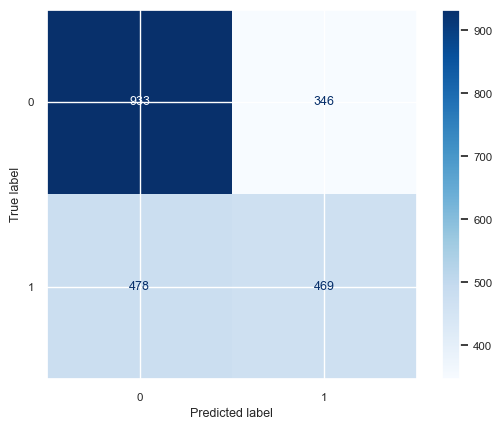

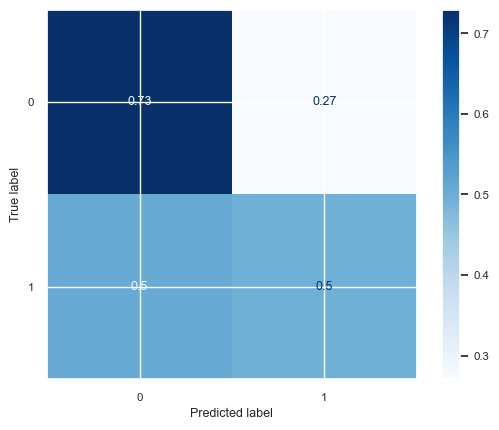

In [206]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test_cat, y_pred_classSvm, labels=svm.classes_,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )

    print(title)
    print(disp.confusion_matrix)

#### 3.3.2 SVM - Classification - Enhance grid search for a better industrialization of the model


###### At this stage we managed to get the best parameters of the SVM Classifier. However, the cost in term of running time is significant : the grid search run for more than half a day.

###### Therefore we analysed deeper the SVM model parameters and the grid search parameters.

###### Main conclusions of our analyses on the SVM model parameters : increase C and/or gamma lead us to an overfitting situation where we pass the sweet spot (the training score is more and more far/higher from/than the test score which can even decrease). Therefore we removed the highest parameter values from the grid. Similar with the lowest value of the grid (underfitting).

In [67]:
C_values = [0.1,1,10]
gamma_values = [0.1,1,10]
C_list = []
gamma_list = []
train_score = []
test_score = []

for C_value in C_values:
    for gamma_value in gamma_values:
        svm_M = SVC(kernel='rbf', C=C_value, gamma = gamma_value).fit(X_train_cat, y_train_cat)
        C_list.append(C_value)
        gamma_list.append(gamma_value)
        train_score.append(svm_M.score(X_train_cat, y_train_cat))
        test_score.append(svm_M.score(X_test_cat, y_test_cat))
        print("C: {:.2f}, gamma : {:.2f}".format(C_value, gamma_value))
        print("Training set score: {:.2f}".format(svm_M.score(X_train_cat, y_train_cat)))
        print("Test set score: {:.2f}".format(svm_M.score(X_test_cat, y_test_cat)))

C: 0.10, gamma : 0.10
Training set score: 0.61
Test set score: 0.62
C: 0.10, gamma : 1.00
Training set score: 0.63
Test set score: 0.63
C: 0.10, gamma : 10.00
Training set score: 0.58
Test set score: 0.57
C: 1.00, gamma : 0.10
Training set score: 0.62
Test set score: 0.62
C: 1.00, gamma : 1.00
Training set score: 0.66
Test set score: 0.63
C: 1.00, gamma : 10.00
Training set score: 0.81
Test set score: 0.61
C: 10.00, gamma : 0.10
Training set score: 0.63
Test set score: 0.63
C: 10.00, gamma : 1.00
Training set score: 0.69
Test set score: 0.64
C: 10.00, gamma : 10.00
Training set score: 0.90
Test set score: 0.59


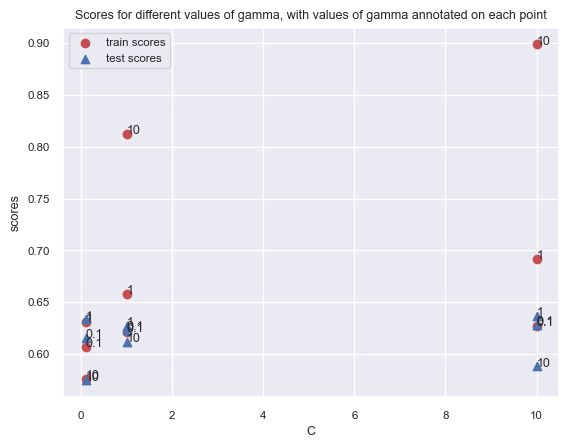

In [76]:
x =C_list
y =gamma_list
z_train =train_score
z_test =test_score

fig, ax = plt.subplots()
ax.scatter(x, z_train, c='r', marker='o', label = 'train scores')
ax.scatter(x, z_test, c='b', marker='^', label = 'test scores')
for i, num in enumerate(y):
    ax.annotate(num, (x[i], z_train[i]))
for i, num in enumerate(y):
    ax.annotate(num, (x[i], z_test[i]))

ax.set_xlabel('C')
ax.set_ylabel('scores')
ax.set_title('Scores for different values of C, and values of gamma annotated on each point')

plt.legend(loc = "upper left")

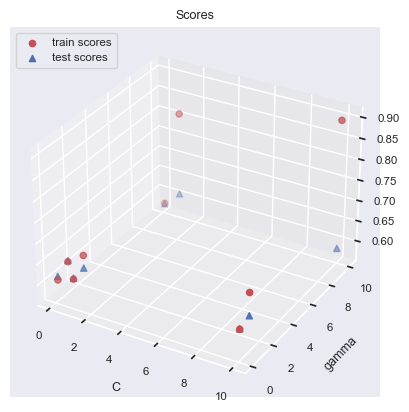

In [74]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z_train, c='r', marker='o', label = 'train scores')
ax.scatter(x, y, z_test, c='b', marker='^', label = 'test scores')

ax.set_xlabel('C')
ax.set_ylabel('gamma')
ax.set_zlabel('score')
ax.set_title('Scores')

plt.legend(loc = "upper left")

plt.show()

###### Main conclusions of our analyses on the parameter of the grid : the number of iterations allows to do a trade of between the running time and the quality of the solution. By reducing the number of iterations from 100 to 48 then 11 we were able to run the grid search for lees than 5 minutes (instead of half a day) and get the same solution.

###### Finally : we reduce the size of the grid search with a better choice of the set of parameters (C and gamma). Furthermore, we reduced the number of iterations used in the grid (n_iter) without loosing the quality of the solution found. Therefore we end up with a more reasonable usage of the hardtwares in terms of resources and running time allowing us to put this material in an automatic Continuous Integration (CI) process (in Github).

###### Parameters used during the original grid search have been commented in the code of this notebook and replaced by the new ones identified after our analyses.

#### 3.3.3 RF - Classification 

In [96]:
#Let's focus on Random Forest then and use a Grid search for hyperparameters in addition to the cross validation

#WARNING : it can take up to 50 mn to run with stop=2000
#WARNING : it can take up to 10 mn to run with stop=101
n_estimators = [int(x) for x in np.linspace(start=100, stop=101, num=20)]
max_features = ["log2", "sqrt"]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# grid
random_gridRF = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}


#hyperparameters random search
rf = RandomForestClassifier()#class_weight="balanced"

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_gridRF,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=50,
    n_jobs=-1,
)

rf_random.fit(X_train_cat, y_train_cat)

print("Corresponding best cross validations score is:\n{}\n".format(rf_random.best_score_))

#Results of hyperparameters random search 
print("Best parameters of Random Forest after grid search and cross validations are:\n {}\n".format(rf_random.best_params_))

#Fitting 5 folds for each of 100 candidates, totalling 500 fits
#Corresponding best cross validations score is:
#0.6299306663974915

#Best parameters of Random Forest after grid search and cross validations are:
# {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'
#, 'max_depth': 100, 'bootstrap': True}


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Corresponding best cross validations score is:
0.6299306663974915

Best parameters of Random Forest after grid search and cross validations are:
 {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}



###### Tune the RF with the best parameters found

In [43]:
RF = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features="sqrt",
    max_depth=100,
    bootstrap=True,
    random_state=1,
    #class_weight="balanced",
)

RF.fit(X_train_cat, y_train_cat)
# prediccion
yhatRF = RF.predict_proba(X_test_cat)

print(yhatRF)

[[0.19839022 0.80160978]
 [0.18270344 0.81729656]
 [0.63283308 0.36716692]
 ...
 [0.72201945 0.27798055]
 [0.6453129  0.3546871 ]
 [0.65105725 0.34894275]]


Feature: 0, Score: 0.38531
Feature: 1, Score: 0.28715
Feature: 2, Score: 0.17713
Feature: 3, Score: 0.12446
Feature: 4, Score: 0.00451
Feature: 5, Score: 0.00126
Feature: 6, Score: 0.01218
Feature: 7, Score: 0.00421
Feature: 8, Score: 0.00379


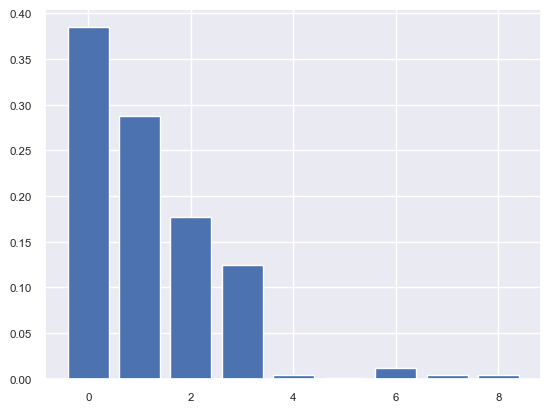

In [44]:
# variable importances
importRF = RF.feature_importances_  # also known as the Gini importance.
for i, v in enumerate(importRF):
    print("Feature: %0d, Score: %.5f" % (i, v))

plt.bar([x for x in range(len(importRF))], importRF)
plt.show()


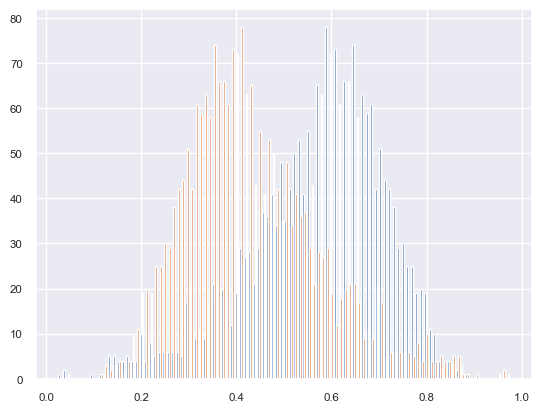

In [45]:
# Histogram of probabilities 
plt.hist(yhatRF, bins=100)
plt.show()

#### Model evaluation

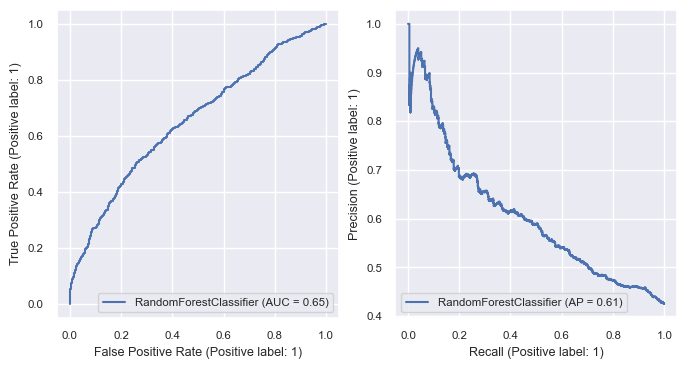

In [46]:
y_predRF = yhatRF[:, 1] #positive class predicted (probabilities)

roc_display = RocCurveDisplay.from_estimator(RF, X_test_cat, y_test_cat)
plt.close()
pr_display = PrecisionRecallDisplay.from_estimator(RF, X_test_cat, y_test_cat)
plt.close()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)


In [48]:
#function to define the variable in terms of category, based on a threshold.
def to_labels(ped,t):
    a = np.where(ped>t, 1, 0)
    return a

#potential thresholds
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold: F2-measure Less weight in precision, more weight in recall.
scoresfbetaRF = [
    fbeta_score(y_test_cat, to_labels(y_predRF, t), average="binary", beta=1)
    for t in thresholds
]

# Threshold and fbeta2_score selected
ixscoresfbetaRF = np.argmax(scoresfbetaRF)
print(
    "Threshold=%.3f, fbeta_score=%.5f"
    % (thresholds[ixscoresfbetaRF], scoresfbetaRF[ixscoresfbetaRF])
)

#result: 

Threshold=0.286, fbeta_score=0.61356


In [50]:
#Apply the Threshold=0.286
y_pred_class = to_labels(y_predRF, 0.4)

print(classification_report(y_test_cat, y_pred_class))
print("ROC AUC score:", roc_auc_score(y_test_cat, y_pred_class))


              precision    recall  f1-score   support

           0       0.68      0.55      0.61      1279
           1       0.52      0.65      0.58       947

    accuracy                           0.60      2226
   macro avg       0.60      0.60      0.60      2226
weighted avg       0.61      0.60      0.60      2226

ROC AUC score: 0.6039912055105089


Confusion matrix, without normalization
[[709 570]
 [328 619]]
Normalized confusion matrix
[[0.55 0.45]
 [0.35 0.65]]


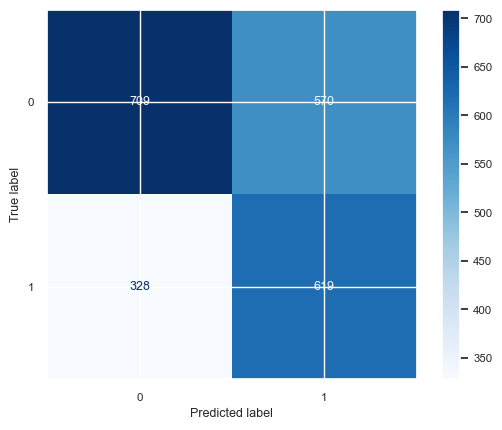

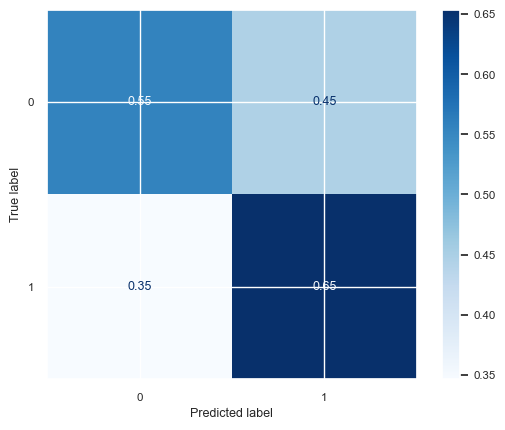

In [51]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test_cat, y_pred_class, labels=RF.classes_,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )

    print(title)
    print(disp.confusion_matrix)

##### Saving the model

In [52]:
from joblib import dump, load

#model
dump(RF,"modelRF.joblib")

### guardar los parámetros de la transformación

dump(dt, "RF_DataTransform.joblib")


['RF_DataTransform.joblib']

#### Model adding author_books_avg_rating column

In [230]:
#Data of interest 
col = ['num_pages', 'text_reviews_count', "author_number_books",'author_books_avg_rating',
        'publicationYear','language_code_grouped', 'catRating','average_rating']

dfmodel = df[col].copy()

dicCat = {"HigRat": "1",
        "LMRat": "0"}

dfmodel["catRating"] = dfmodel["catRating"].apply(lambda x: dicCat[x])


#%%outliers
columns =['num_pages','text_reviews_count', "author_number_books"] 

for c in columns:
    data_mean, data_std = np.mean(dfmodel[c]), np.std(dfmodel[c])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    dfmodel[c]= [upper if x > upper else x for x in df[c]]


In [231]:

X = dfmodel[['num_pages', 'text_reviews_count', 'publicationYear','language_code_grouped'
             ,'author_number_books', 'author_books_avg_rating']]
y = dfmodel.loc[:, "catRating"]

#split the data
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y, train_size=0.8, random_state=1, stratify=y
)

#Encode target column
label_encode = LabelEncoder()
label_encode.fit(y_train_cat)
y_train_cat = label_encode.transform(y_train_cat)
y_test_cat = label_encode.transform(y_test_cat)

cont_ix = X_train_cat.select_dtypes(exclude=["object"]).columns
cat_ix = X_train_cat.select_dtypes(include=["object"]).columns
print(cont_ix)
print(cat_ix)


Index(['num_pages', 'text_reviews_count', 'publicationYear',
       'author_number_books', 'author_books_avg_rating'],
      dtype='object')
Index(['language_code_grouped'], dtype='object')


array([[<Axes: title={'center': 'cont__num_pages'}>,
        <Axes: title={'center': 'cont__text_reviews_count'}>],
       [<Axes: title={'center': 'cont__publicationYear'}>,
        <Axes: title={'center': 'cont__author_number_books'}>],
       [<Axes: title={'center': 'cont__author_books_avg_rating'}>,
        <Axes: >]], dtype=object)

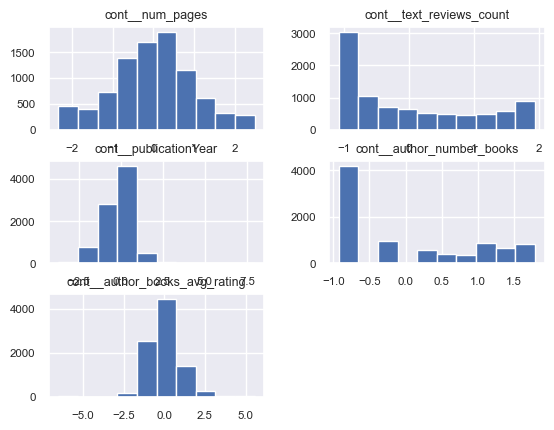

In [233]:

cont_pipeline = make_pipeline(
    RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0)),
    PowerTransformer(method="yeo-johnson")
)

cat_pipeline = make_pipeline(OneHotEncoder(drop="first"))

preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_pipeline, cont_ix),
        ("cat", cat_pipeline, cat_ix),
    ]
)

dt = Pipeline(steps=[("preprocessor", preprocessor)])
dt.fit(X_train_cat)

X_train_cat_dt = dt.transform(X_train_cat)

#Final data set
var_list = list(dt.get_feature_names_out())
X_train_cat = pd.DataFrame(X_train_cat_dt, columns=var_list)

X_test_cat_dt = dt.transform(X_test_cat)
X_test_cat = pd.DataFrame(X_test_cat_dt, columns=var_list)

X_train_cat[['cont__num_pages','cont__text_reviews_count','cont__publicationYear','cont__author_number_books', 'cont__author_books_avg_rating']].hist()


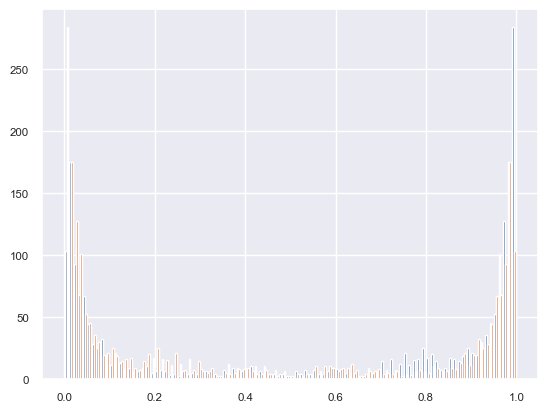

In [234]:

#train the model
RF = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features="sqrt",
    max_depth=100,
    bootstrap=True,
    random_state=1
)

RF.fit(X_train_cat, y_train_cat)
# prediccion
yhatRF = RF.predict_proba(X_test_cat)

# Histogram of probabilities 
plt.hist(yhatRF, bins=100)
plt.show()


In [236]:

y_predRF = yhatRF[:, 1] #positive class predicted (probabilities)

#Apply the Threshold
y_pred_class = to_labels(y_predRF, 0.4)

print(classification_report(y_test_cat, y_pred_class))
print("ROC AUC score:", roc_auc_score(y_test_cat, y_pred_class))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1279
           1       0.88      0.91      0.90       947

    accuracy                           0.91      2226
   macro avg       0.91      0.91      0.91      2226
weighted avg       0.91      0.91      0.91      2226

ROC AUC score: 0.9100476134255493
